In [20]:
from scipy import signal
import numpy as np
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.utils import shuffle


import sys
sys.path.append('../')
from Utils.constants import TRAIN_FILES, TEST_FILES
from Utils.perturbations import RBPIndividual, zeroPerturb, noisePerturb, blurPerturb
from Utils.data import *

In [2]:
import os
import sys

# 获取当前运行的 ipynb 文件所在目录
current_dir = os.path.dirname(os.path.abspath("__file__"))

# 向上查找，直到找到指定的文件夹
target_folder = "LIMESegment"  # 你想作为起始路径的文件夹名
path = current_dir

while os.path.basename(path) != target_folder:
    path = os.path.dirname(path)  # 一层一层向上找

# 打印路径以确认
print("设置的路径起始位置:", path)


设置的路径起始位置: /Users/gali/Desktop/LIMESegment


In [18]:
import numpy as np
def ReadTS(name):
    data_path = os.path.join(path, f"Univariate_arff/{name}/{name}_TEST.txt")
    
    # 读取文件中的数据并存储为 NumPy 数组
    test = np.loadtxt(data_path)

    data_path = os.path.join(path, f"Univariate_arff/{name}/{name}_TRAIN.txt")
    
    train = np.loadtxt(data_path)

    #print("数据形状:", ACSF1_test.shape)
    #print("数据内容:\n", ACSF1_test)
    
    # # 获取第一列
    first_column = train[:, 0]
    
    # # 统计每个数字的频次
    unique, counts = np.unique(first_column, return_counts=True)
    
    # # 将结果组合为字典
    freq_dict = dict(zip(unique, counts))
    
    print(freq_dict)
    
    # 第一列作为标签 y_train
    y_train = train[:, 0]
    print(y_train.shape)
    # 剩余部分作为特征 x_train
    x_train = train[:, 1:]
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    print(x_train.shape)
    
    y_test= test[:, 0]
    
    x_test = test[:, 1:]
    
    # print("x_train:\n", x_train)
    # print("y_train:\n", y_train)

    return x_train, y_train, x_test, y_test

ReadTS('ChlorineConcentration')

    



{1.0: 114, 2.0: 91, 3.0: 262}
(467,)
(467, 166, 1)


(array([[[ 2.6173319 ],
         [ 3.230977  ],
         [ 2.8508    ],
         ...,
         [-1.005866  ],
         [-0.79022051],
         [-0.8463201 ]],
 
        [[ 1.9822955 ],
         [ 3.4956068 ],
         [ 3.1081047 ],
         ...,
         [-0.845186  ],
         [-0.58468125],
         [-0.64563684]],
 
        [[ 4.8586386 ],
         [ 4.5758307 ],
         [ 4.14975   ],
         ...,
         [-0.73030062],
         [-0.46326055],
         [-0.5145763 ]],
 
        ...,
 
        [[ 5.2105854 ],
         [ 4.8390478 ],
         [ 4.4075914 ],
         ...,
         [-0.59218622],
         [-0.38219181],
         [-0.45793724]],
 
        [[ 1.0372081 ],
         [ 3.5039899 ],
         [ 3.1470819 ],
         ...,
         [-1.0905219 ],
         [-0.79988862],
         [-0.88711023]],
 
        [[ 2.0836382 ],
         [ 3.5073305 ],
         [ 3.116688  ],
         ...,
         [-0.81557137],
         [-0.54351037],
         [-0.60048001]]]),
 array([1., 3., 1.,

In [8]:
X_train, y_train, X_test, y_test, nb_classes = loadUCRDataID(0)
# print(X_train)
# print(type(X_train))
# print(type(X_train[0]))
# print(len(X_train[0]))

Loading train / test dataset :  ../Data/Coffee_TRAIN ../Data/Coffee_TEST


In [ ]:
#The second background identification approach which combines the most significant frequency component 
#of every sample into a spectral matrix and identify the background in this matrix


#Identify backgrounds in a single TS
def backgroundfreqIdentification(original_signal):
    f, t, Zxx = signal.stft(original_signal,fs = 1,nperseg=40, noverlap = 20)
    frequency_composition_abs = np.abs(Zxx)
    measures = []
    for freq,freq_composition in zip(f,frequency_composition_abs):
        measures.append(np.mean(freq_composition)/np.std(freq_composition))
    max_value = max(measures)
    selected_frequency = measures.index(max_value)
    # create a zero matrix
    Zxx_candidate = np.zeros_like(Zxx, dtype=complex)
    # insert the selected component into selected frequency
    Zxx_candidate[selected_frequency, :] = Zxx[selected_frequency, :]
    # weights = 1-(measures/sum(measures))
    # dummymatrix = np.zeros((len(f),len(t)))
    # dummymatrix[selected_frequency,:] = 1  
    # #Option to admit information from other frequency bands
    # """dummymatrix = np.ones((len(f),len(t)))
    # for i in range(0,len(weights)):
    #     dummymatrix[i,:] = dummymatrix[i,:] * weights[i]"""
    
    # background_frequency = Zxx * dummymatrix
    # _, xrec = signal.istft(background_frequency, 1)
    return Zxx_candidate



#Background Identification
def candidatebackgroundIdentification(global_signals):
    #Set up template matrix
    test_sig = global_signals[0].flatten()
    print(global_signals[0])
    f_, t_, Zxx_ = signal.stft(test_sig,1,nperseg=40)
    Zxx = np.zeros_like(Zxx_, dtype=complex)

    #For every sample, return a spectral matrix representing the background 
    for i in range(1,len(global_signals)):
        test_sig = global_signals[i].flatten()
        Zxx_candidate = backgroundfreqIdentification(test_sig)
        assert Zxx.shape == Zxx_candidate.shape, f"Shape mismatch at signal {i}"
        #Add all backgrounds together
        Zxx = Zxx + Zxx_candidate
        print(i)
    print(Zxx.shape)
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t_, f_, np.abs(Zxx), shading='gouraud') 
    plt.title('STFT Magnitude Spectrum')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.colorbar(label='Magnitude')
    
    plt.ylim(np.min(f_), 0.1)
    
    plt.show()
    frequency_composition_abs = np.abs(Zxx)
    measures = []
    for freq,freq_composition in zip(f_,frequency_composition_abs):
        measures.append(np.mean(freq_composition)/np.std(freq_composition))
    max_value = max(measures)
    selected_frequency = measures.index(max_value)
    weights = 1-(measures/sum(measures))
    dummymatrix = np.zeros((len(f_),len(t_)))
    dummymatrix[selected_frequency,:] = 1  
    #Option to admit information from other frequency bands
    """dummymatrix = np.ones((len(f),len(t)))
    for i in range(0,len(weights)):
        dummymatrix[i,:] = dummymatrix[i,:] * weights[i]"""
    
    background_frequency = Zxx * dummymatrix
    _, xrec = signal.istft(background_frequency, 1)
    return xrec,f_,t_,Zxx


rec,f,t,Zxx = candidatebackgroundIdentification(X_train)

In [24]:
def multisamplebackgroundIdentification(global_signals):
    test_sig = global_signals[0].flatten()
    f, t, Zxx = signal.stft(test_sig,1,nperseg=40)
    for i in range(1,len(global_signals)):
        test_sig = global_signals[i].flatten()
        f0, t0, Zxx0 = signal.stft(test_sig,1,nperseg=40, noverlap = 20)
        assert Zxx.shape == Zxx0.shape, f"Shape mismatch at signal {i}"
        Zxx = Zxx + Zxx0
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud') 
    plt.title('STFT Magnitude Spectrum')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.colorbar(label='Magnitude')
    plt.ylim(np.min(f), 0.1)
    plt.show()
    frequency_composition_abs = np.abs(Zxx)
    measures = []
    for freq,freq_composition in zip(f,frequency_composition_abs):
        measures.append(np.mean(freq_composition)/np.std(freq_composition))
    max_value = max(measures)
    selected_frequency = measures.index(max_value)
    weights = 1-(measures/sum(measures))
    dummymatrix = np.zeros((len(f),len(t)))
    dummymatrix[selected_frequency,:] = 1  
    #Option to admit information from other frequency bands
    """dummymatrix = np.ones((len(f),len(t)))
    for i in range(0,len(weights)):
        dummymatrix[i,:] = dummymatrix[i,:] * weights[i]"""
    
    background_frequency = Zxx * dummymatrix
    _, xrec = signal.istft(background_frequency, 1)
    return xrec,f,t,Zxx



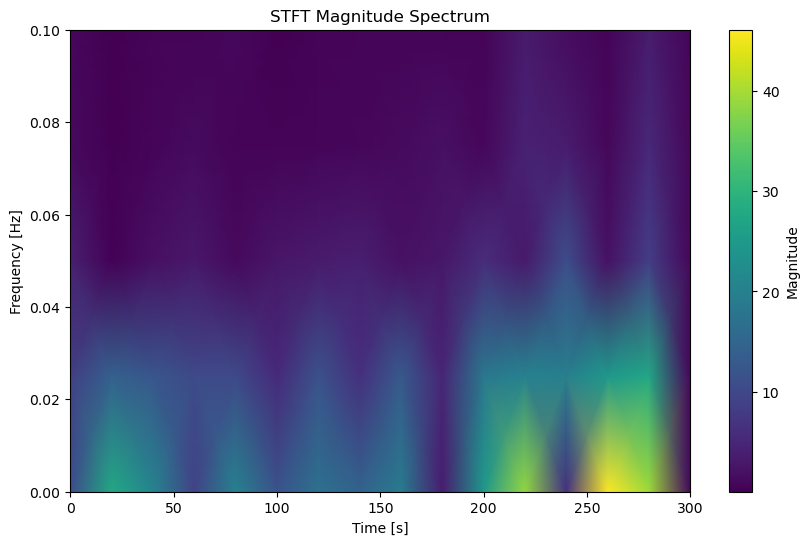

In [25]:
rec,f,t,Zxx = multisamplebackgroundIdentification(X_train)

286
(21, 16)


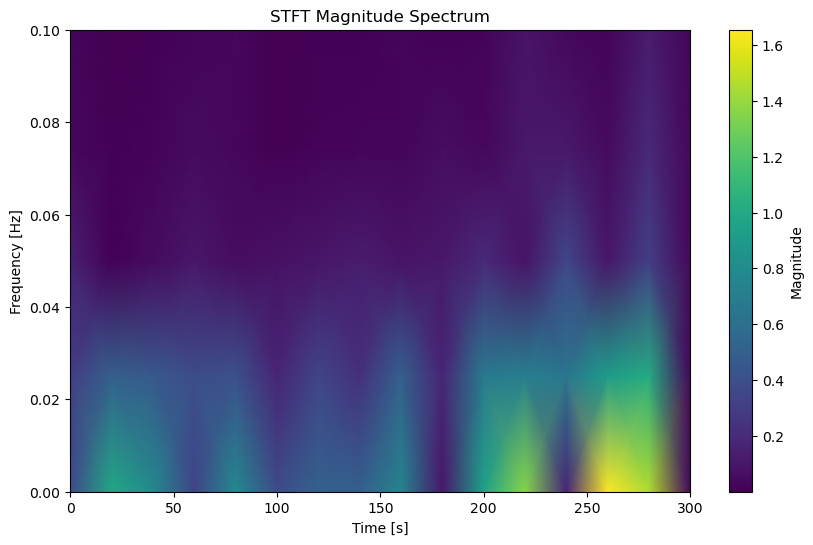

In [45]:


def backgroundIdentification(original_signal):
    f, t, Zxx = signal.stft(original_signal,fs = 1,nperseg=40, noverlap = 20)
    print(Zxx.shape)
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud') 
    plt.title('STFT Magnitude Spectrum')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.colorbar(label='Magnitude')
    plt.ylim(np.min(f), 0.1)
    plt.show()
    frequency_composition_abs = np.abs(Zxx)
    measures = []
    for freq,freq_composition in zip(f,frequency_composition_abs):
        measures.append(np.mean(freq_composition)/np.std(freq_composition))
    max_value = max(measures)
    selected_frequency = measures.index(max_value)
    weights = 1-(measures/sum(measures))
    dummymatrix = np.zeros((len(f),len(t)))
    dummymatrix[selected_frequency,:] = 1  
    #Option to admit information from other frequency bands
    """dummymatrix = np.ones((len(f),len(t)))
    for i in range(0,len(weights)):
        dummymatrix[i,:] = dummymatrix[i,:] * weights[i]"""
    
    background_frequency = Zxx * dummymatrix
    _, xrec = signal.istft(background_frequency, 1)
    return xrec

print(len(X_train[0]))
test_sig = X_train[0].flatten()
#print(test_sig)
#f, t, Zxx = signal.stft(test_sig,fs = 1,nperseg=40, noverlap = 20)
rec = backgroundIdentification(test_sig)



In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow
print(tensorflow.__version__)

2.12.0


In [1]:
import platform
platform.platform()

'macOS-14.1.1-arm64-arm-64bit'

In [4]:
import sys
sys.path.append('../')
from Utils.perturbationsnew import RBPIndividual, RBPIndividualNew1, RBPIndividualNew2, zeroPerturb, noisePerturb, blurPerturb
from Utils.models import *
from Utils.data import perturb, generateSynthetic, generateSyntheticPerturbReal

print(sys.path)